In [43]:
from PIL import Image, ImageDraw, ImageFont

from tkinter import Tk
from tkinter.filedialog import askopenfilename

import math
import os
import numpy as np

# DMD dimensions
DMD_ROWS = 1140
DMD_COLS = 912

class PatternPainter:
    def __init__(self) -> None:
        pass

class DMDImage: 
    def __init__(self) -> None:
        """
        DMDImage class is used to store the DMD image in a 2D array of 1s and 0s, where 1 
        represents a white pixel (on) and 0 represents a black pixel (off).

        --------------------
        Attributes:
        --------------------
        template: PIL Image object
            The template image in real space, which is the image that will be converted to DMD space
        dmdarray: PIL Image object
            The DMD image in DMD space, which is the image that will be displayed on the DMD
        rows: int
            Number of rows in the DMD image
        cols: int
            Number of columns in the DMD image
        real_rows: int
            Number of rows in the real space image
        real_cols: int
            Number of columns in the real space image
        """
        self.rows = DMD_ROWS
        self.cols = DMD_COLS

        self.real_rows = math.ceil((self.rows-1) / 2) + self.cols
        self.real_cols = self.cols + (self.rows-1) // 2

        self.template = np.full((self.real_rows, self.real_cols, 3), (255, 0, 0), dtype=np.uint8)
        self.dmdarray = np.full((self.rows, self.cols, 3), 0, dtype=np.uint8)

        row, col = np.meshgrid(np.arange(self.rows), np.arange(self.cols), indexing='ij')
        self.dmdrows, self.dmdcols = self.realSpace(row.flatten(), col.flatten())

    def realSpace(self, row, col):
        """
        Convert the given DMD space row and column to real space row and column
        --------------------
        Parameters:
        --------------------
        row: int
            Row in DMD space
        col: int
            Column in DMD space
        
        --------------------
        Returns:
        --------------------
        real_row: int
            Row in real space
        real_col: int
            Column in real space
        """
        return (np.ceil(row/2)).astype(int) + col, self.cols - 1 + row//2 - col
    
    def setTemplate(self, color=1):
        """
        Set the template image in real space to a solid color
        --------------------
        Parameters:
        --------------------
        color: int
            1 for white (on), 0 for black (off)
        """
        # Paint all pixels within DMD space to white/black, default is white (on)
        self.template[self.dmdrows, self.dmdcols, :] = color * np.array([255, 255, 255])
        self.dmdarray[:] = color * 255
    
    def getTemplateImage(self, color=1):
        """
        Return a PIL Image object of the template image in real space with labels on the corners
        --------------------
        Parameters:
        --------------------
        color: int
            1 for white (on), 0 for black (off)
        
        --------------------
        Returns:
        --------------------
        template: PIL Image object
            The template image in real space
        """
        self.setTemplate(color=color)
        template = Image.fromarray(self.template, mode='RGB')        
        
        # Add labels on the corners
        draw = ImageDraw.Draw(template)
        font = ImageFont.truetype("arial.ttf", 30)

        corner00 = self.realSpace(0, 0)[1] - 100, self.realSpace(0, 0)[0]
        corner10 = self.realSpace(self.rows-1, 0)[1] - 150, self.realSpace(self.rows-1, 0)[0] + 150
        corner11 = self.realSpace(self.rows-1, self.cols-1)[1] + 50, self.realSpace(self.rows-1, self.cols-1)[0] - 50

        draw.text(corner00, '(0, 0)', font=font, fill=0)
        draw.text(corner10, f'({self.rows-1}, 0)', font=font, fill=0)
        draw.text(corner11, f'({self.rows-1}, {self.cols-1})', font=font, fill=0)
        return template

    def convertImageToDMDArray(self, image):
        assert image.size == (self.real_cols, self.real_rows)
        self.template[:, :, :] = np.asarray(image, dtype=np.uint8)
        self.convertTemplateToDMDArray()
    
    def convertTemplateToDMDArray(self):
        # Loop through every column and row for the DMD image and assign it 
        # the corresponding pixel value from the real space image
        self.dmdarray[:, :, :] = self.template[self.dmdrows, self.dmdcols, :].reshape(self.rows, self.cols, 3)
    
    def saveDMDArray(self, filename):
        image = Image.fromarray(self.dmdarray, mode='RGB')
        image.save(filename)
        print('DMD pattern saved as', filename)
        return image
    
    def drawPattern(self, color=1):
        # Reset the real space template
        self.setTemplate(color=1-color)


    
    def drawCircle(self, row_offset=0, col_offset=0, radius=50, color=1):
        # Find the real space center coordinates
        center_row, center_col = self.template.size[1]//2, self.template.size[0]//2
        row, col = center_row + row_offset, center_col + col_offset

        # Draw a circle with the given radius and color on the DMD template
        for i in range(max(0, row-radius), min(row+radius+1, self.template.size[1])):
            for j in range(max(0, col-radius), min(center_col+radius+1, self.template.size[0])):
                
                if (i-row)**2 + (j-col)**2 <= radius**2:
                    if color == 1:
                        self.template.putpixel((j, i), value=(255, 255, 255))
                    elif color == 0:
                        self.template.putpixel((j, i), value=(0, 0, 0))
        
        # Update the DMD array
        self.convertTemplateToDMDArray()
        return

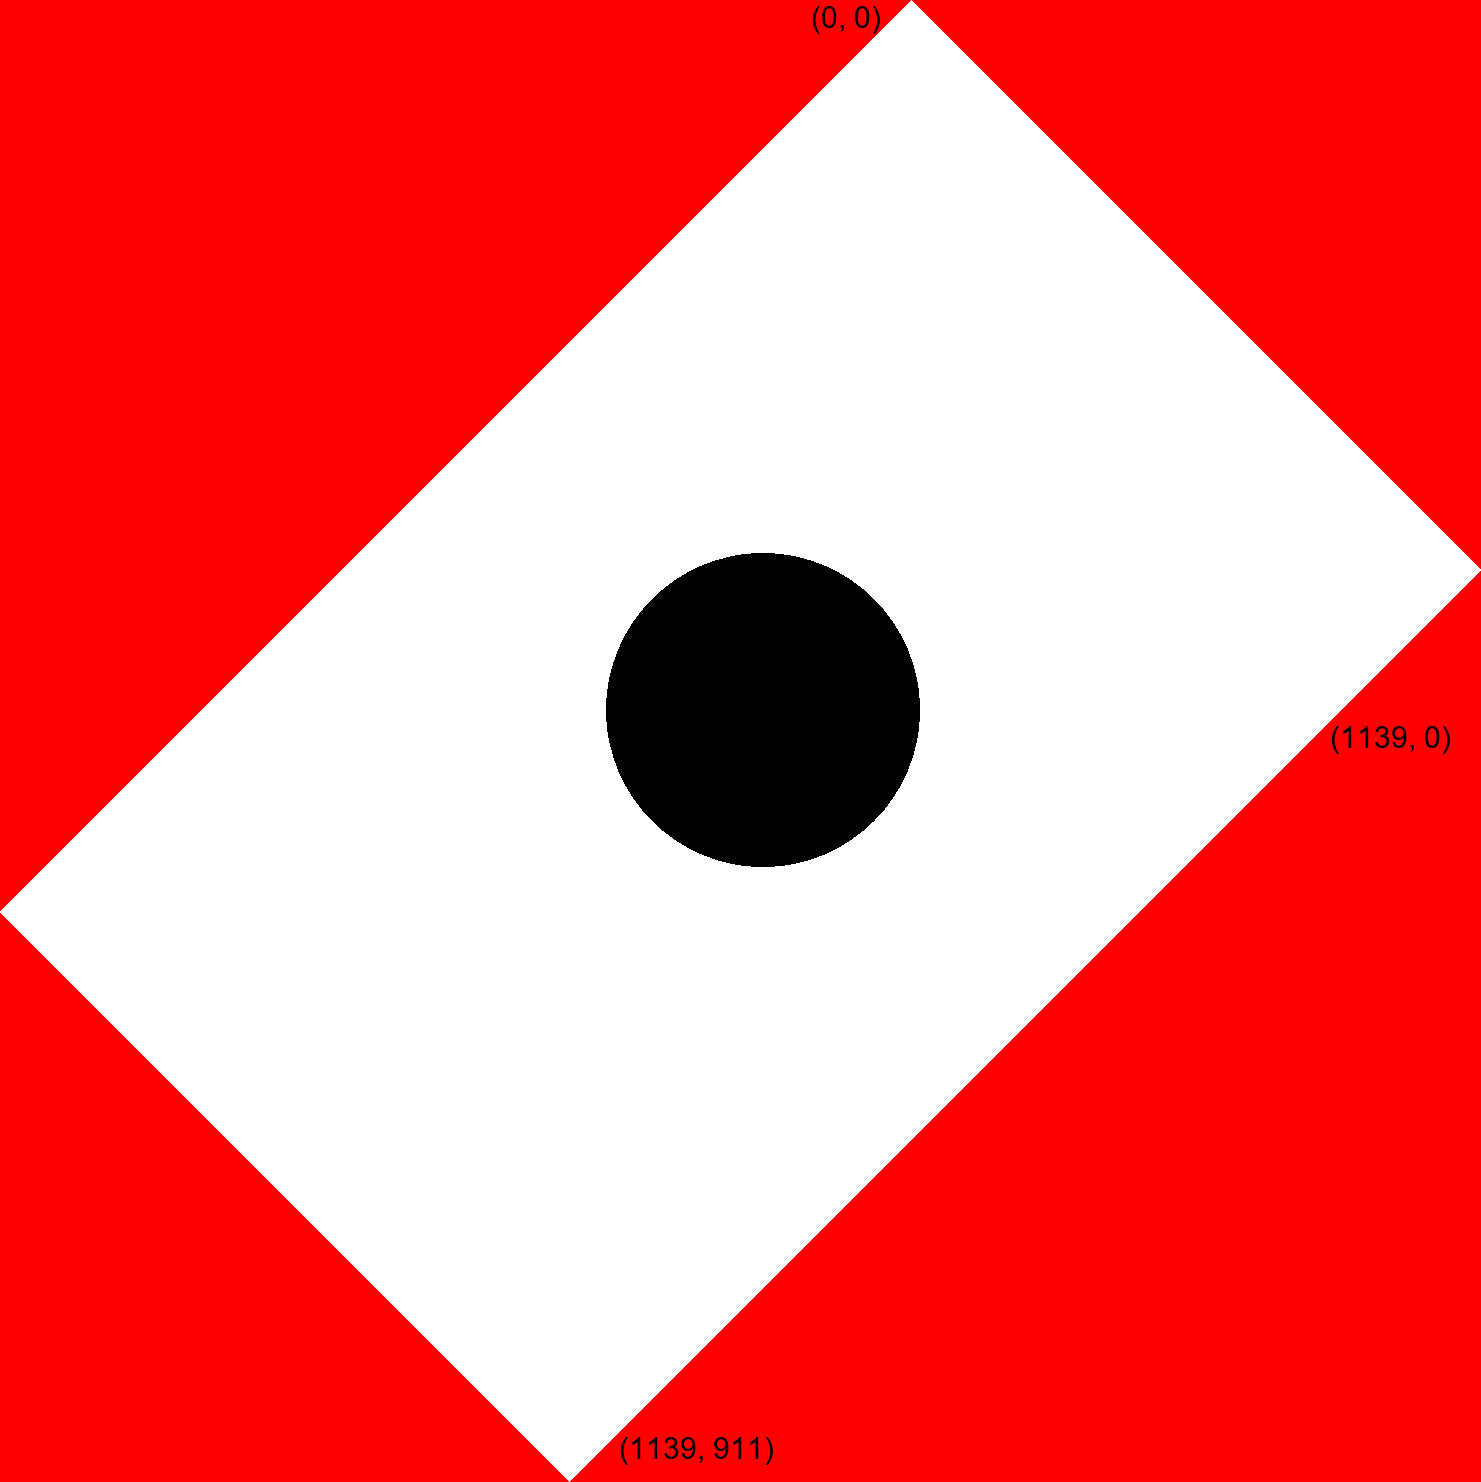

In [45]:
file_path = 'resources/center_circle_bright.bmp'

# Convert the loaded modified template to a DMD Image
dmd_image = DMDImage()
pixels = dmd_image.convertImageToDMDArray(Image.open(file_path).convert('RGB'))
Image.fromarray(pixels, mode='RGB')

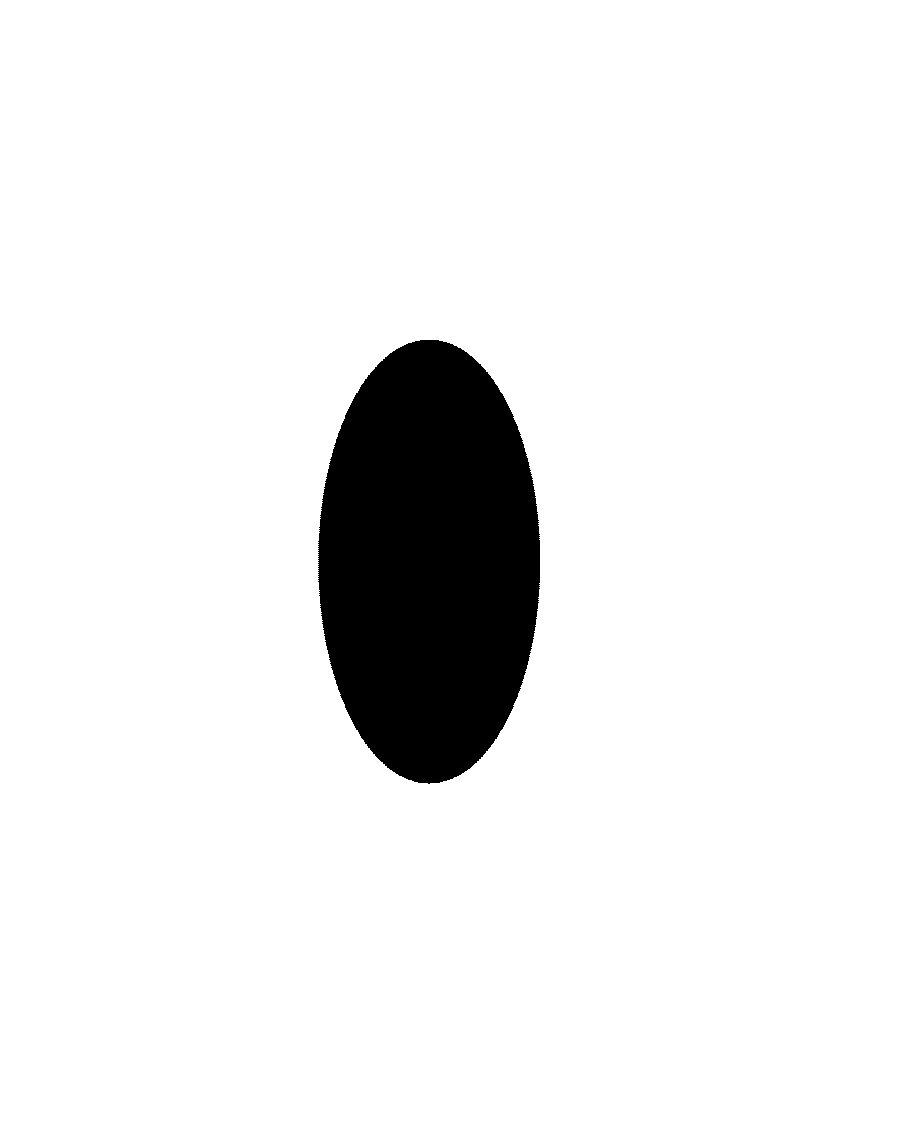

In [46]:
dmd_image.dmdarray[:, :, :] = pixels[dmd_image.dmdrows, dmd_image.dmdcols, :].reshape(dmd_image.rows, dmd_image.cols, 3)
Image.fromarray(dmd_image.dmdarray, mode='RGB')

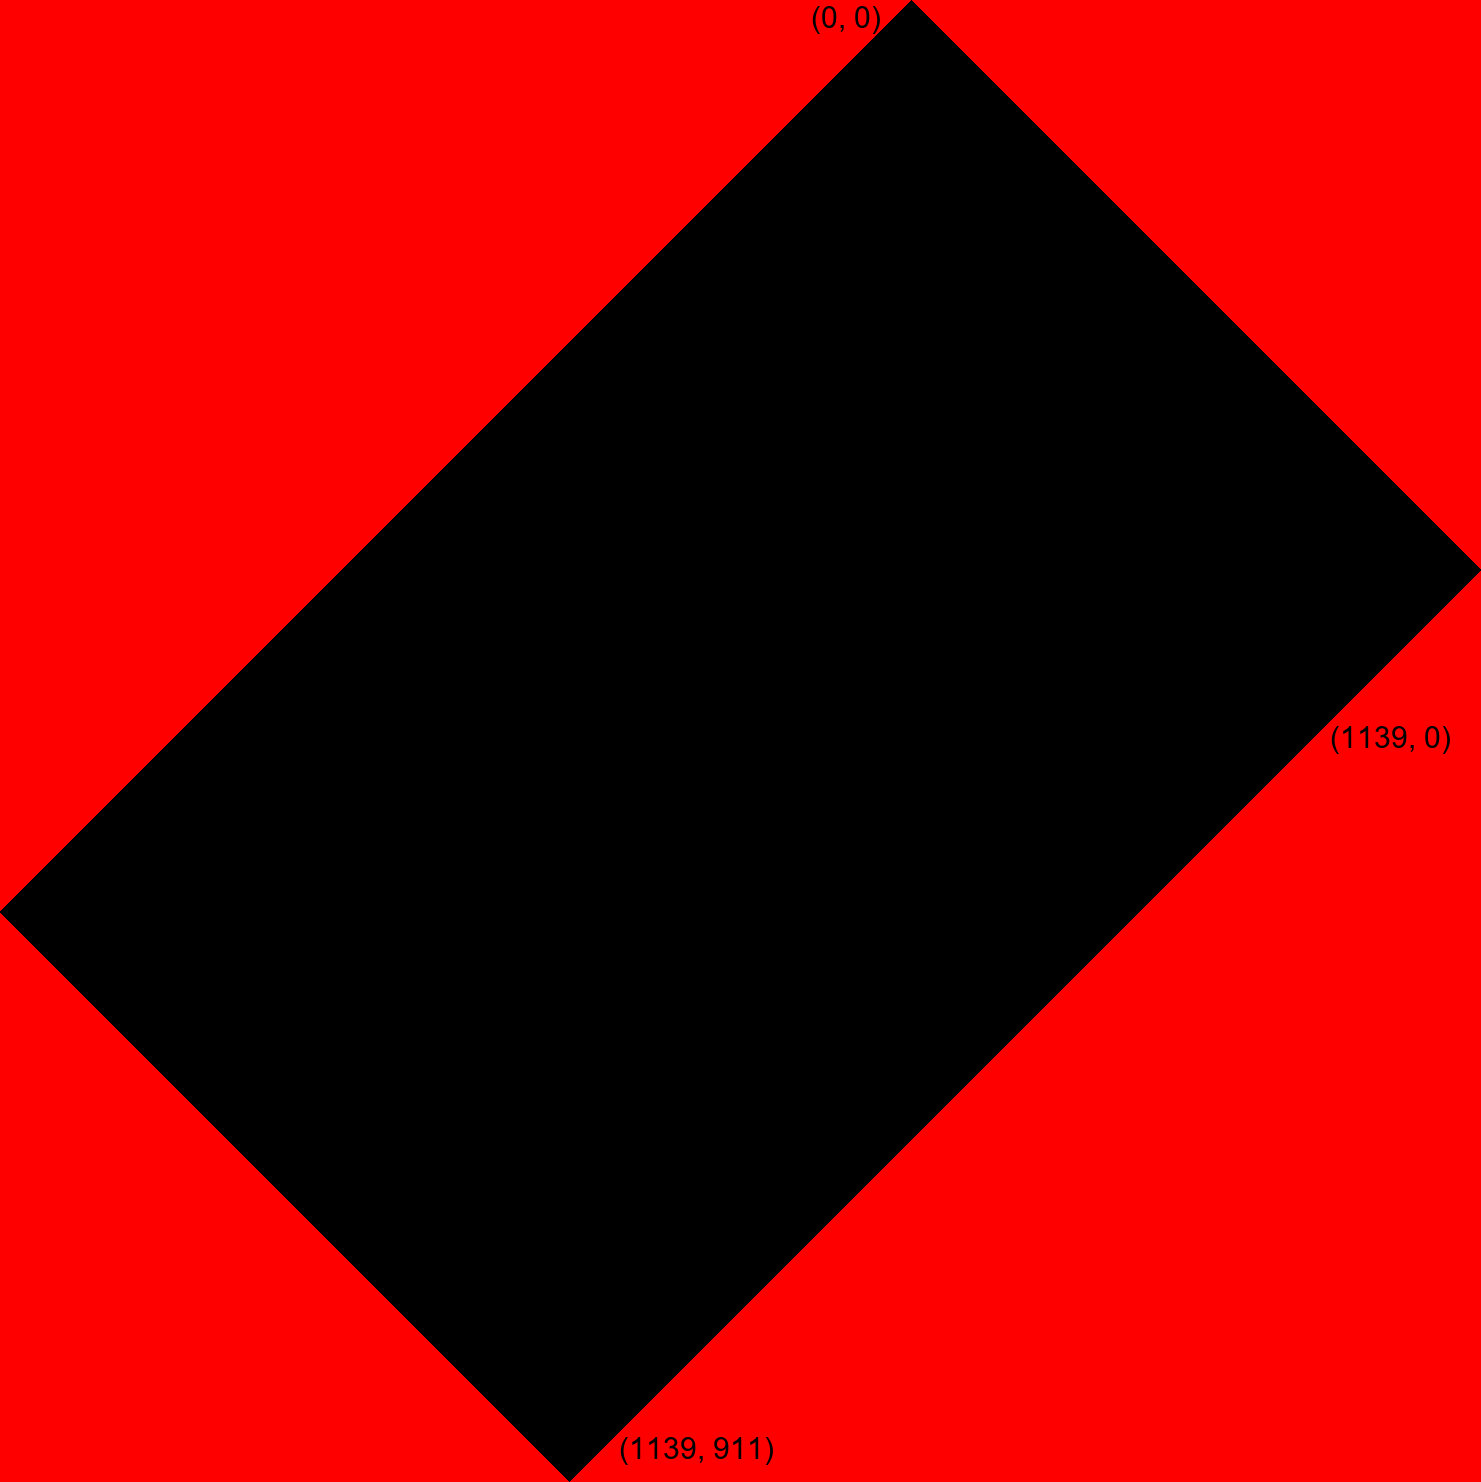

In [16]:
dmd = DMDImage()
image = dmd.getTemplateImage(color=0)
image